In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../../BTDB2_SIMULATOR')
from main import *
from rounds import *
from actions import *

# An Example of Affording R11 HRP

The cash and eco at the end of the simulation is given by (99.89999999998832,651.899999999999)


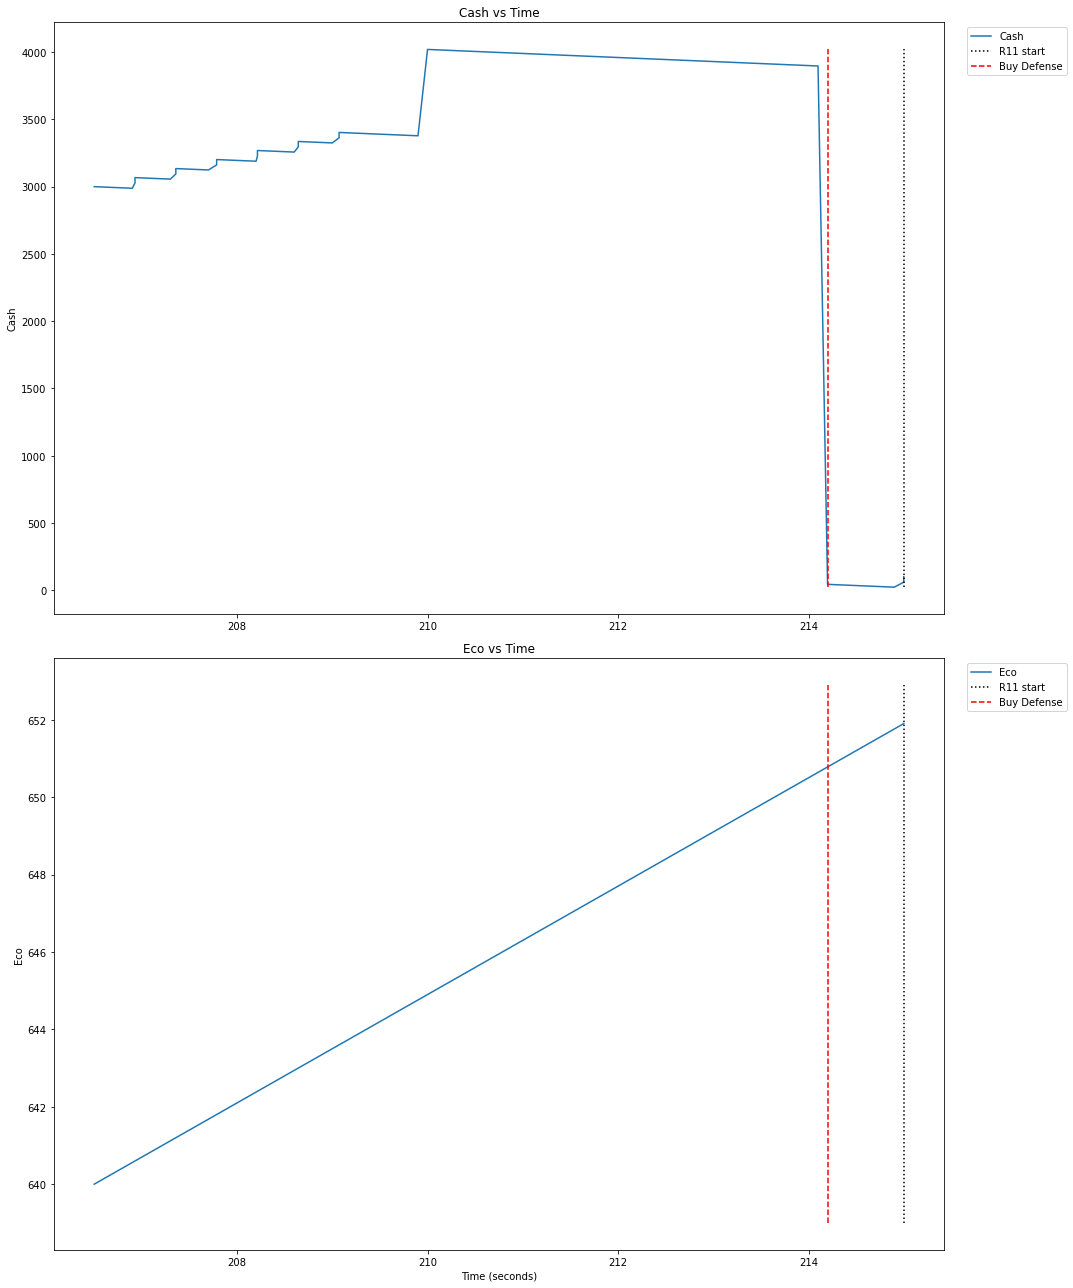

In [2]:
rounds = Rounds(0.0)

buy_queue = [
    [buyDefense(5600-1750, min_buy_time = rounds.getTimeFromRound(10.9))], #Sell 022 dartling into 030 dartling
]

eco_queue = []

farms = {
    0: initFarm(0, upgrades = [2,0,0]),
    1: initFarm(0, upgrades = [2,0,0])
}

initial_state = {
    'Cash': 3000,
    'Eco': 640,
    'Eco Send': 'Spaced Leads',
    'Farms': farms,
    'Rounds': rounds,
    'Game Round': 10,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}

game_state = GameState(initial_state)
game_state.fastForward(target_round=11, interval=0.1)
game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'dartling_HRP')
print("The cash and eco at the end of the simulation is given by (%s,%s)"%(game_state.cash, game_state.eco))

## When do we get the R11 HRP?

In [24]:
def hrpCheck(cash, eco, stall_factor):
    rounds = Rounds(stall_factor)

    buy_queue = [
        [buyDefense(5600-1750, min_buy_time = rounds.getTimeFromRound(10.9))], #Sell 022 dartling into 030 dartling
    ]

    eco_queue = []

    farms = {
        0: initFarm(0, upgrades = [2,0,0]),
        1: initFarm(0, upgrades = [2,0,0])
    }

    initial_state = {
        'Cash': cash,
        'Eco': eco,
        'Eco Send': 'Spaced Leads',
        'Farms': farms,
        'Rounds': rounds,
        'Game Round': 10,
        'Buy Queue': buy_queue,
        'Eco Queue': eco_queue
    }

    game_state = GameState(initial_state)
    game_state.fastForward(target_round=11, interval=0.1)
    #game_state.viewCashEcoHistory()
    #writeLog(game_state.logs, filename = 'dartling_HRP')
    #print("The cash and eco at the end of the simulation is given by (%s,%s)"%(game_state.cash, game_state.eco))

    if len(game_state.buy_queue) == 0:
        return True
    else:
        return False

In [22]:
def hrpCheckGrid(cash_values, eco_values, stall_factor):

    M = len(cash_values)
    N = len(eco_values)

    truth_grid = [[None for j in range(N)] for i in range(M)]

    for i in range(M):
        for j in range(N):
            truth_grid[i][j] = hrpCheck(cash_values[i], eco_values[j], stall_factor)

    return truth_grid

In [12]:
def hrpMinCash(eco, stall_factor, iters = 10, starting_guess = 3000):
    #Use bisection method to determine the minimum cash necessary to have on R10 to afford HRP by R11
    
    #First, we need a suitable starting range to do bisection method with
    if hrpCheck(starting_guess, eco, stall_factor) == True:
        #print("Starting guess too high")
        #In this case, the starting guess is too high.
        b = starting_guess
        while hrpCheck(b, eco, stall_factor) == True:
            if hrpCheck(b/2, eco, stall_factor) == True:
                b = b/2
            else:
                a = b/2
                break
    else:
        #print("Starting guess too low")
        #In this case, the starting guess is too low
        a = starting_guess
        while hrpCheck(a, eco, stall_factor) == False:
            if hrpCheck(2*a, eco, stall_factor) == False:
                a = 2*a
            else:
                #print("TRUE")
                b = 2*a
                break
            #print("Update to %s"%(a))
    
    #print("Set bounds of (%s,%s)"%(a,b))

    #Next, perform bisection method iterations
    for i in range(iters):
        c = 0.5*(a+b)
        if hrpCheck(c, eco, stall_factor) == False:
            a = c
        else:
            b = c
        
        #print("Updated guess to (%s,%s)"%(a,b))
        
    return 0.5*(a+b)


In [25]:
def hrpCheck3d(eco_values, stall_factor_values, iters = 20, starting_guess = 3000):
    #Given a list of eco_values and stall_factor_values, use bisection method to determine the minimum cash necessary to afford HRP on R11 
    M = len(eco_values)
    N = len(stall_factor_values)

    min_cash_array = np.zeros((M,N))

    for i in range(M):
        for j in range(N): 
            min_cash_array[i,j] = np.round(hrpMinCash(eco_values[i], stall_factor_values[j], iters = iters, starting_guess = starting_guess),0)
    
    return min_cash_array
    

In [26]:
A = 17
eco_values = [450 + 400*i/(A-1) for i in range(A)]
stall_factor_values = [0 + 1*i/(A-1) for i in range(A)]

min_cash_array = hrpCheck3d(eco_values,stall_factor_values)

In [27]:
df = pd.DataFrame(min_cash_array, columns = stall_factor_values)
df['eco values'] = eco_values
df.set_index('eco values')

,0.0,0.0625,0.125,0.1875,0.25,0.3125,0.375,0.4375,0.5,0.5625,0.625,0.6875,0.75,0.8125,0.875,0.9375,1.0
eco values,,,,,,,,,,,,,,,,,
450.0,3043.0,3071.0,2637.0,2667.0,3147.0,2710.0,2739.0,2769.0,2331.0,2812.0,2842.0,2400.0,2431.0,2463.0,2469.0,2501.0,2053.0
475.0,3018.0,3046.0,2587.0,2617.0,3122.0,2660.0,2689.0,2719.0,2256.0,2762.0,2791.0,2325.0,2356.0,2388.0,2394.0,2426.0,1953.0
500.0,2993.0,3021.0,2537.0,2567.0,3097.0,2610.0,2639.0,2669.0,2181.0,2712.0,2742.0,2250.0,2281.0,2313.0,2319.0,2351.0,1853.0
525.0,2968.0,2996.0,2487.0,2517.0,3072.0,2560.0,2589.0,2619.0,2106.0,2662.0,2691.0,2175.0,2206.0,2238.0,2244.0,2276.0,1753.0
550.0,2943.0,2971.0,2437.0,2467.0,3047.0,2510.0,2539.0,2569.0,2031.0,2612.0,2642.0,2100.0,2131.0,2163.0,2169.0,2201.0,1653.0
575.0,2918.0,2946.0,2387.0,2417.0,3022.0,2460.0,2489.0,2519.0,1956.0,2562.0,2591.0,2025.0,2056.0,2088.0,2094.0,2126.0,1553.0
600.0,2893.0,2921.0,2337.0,2367.0,2997.0,2410.0,2439.0,2469.0,1881.0,2512.0,2542.0,1950.0,1981.0,2013.0,2019.0,2051.0,1453.0
625.0,2868.0,2896.0,2287.0,2317.0,2972.0,2360.0,2389.0,2419.0,1806.0,2462.0,2491.0,1875.0,1906.0,1938.0,1944.0,1976.0,1353.0
650.0,2843.0,2871.0,2237.0,2267.0,2947.0,2310.0,2339.0,2369.0,1731.0,2412.0,2442.0,1800.0,1831.0,1863.0,1869.0,1901.0,1253.0
